## GEOG0125

Advanced Topics in Social and Geographic Data Science
-----------------------------------

GEOG0125 Assignment
-------------------------------


## 1. Loading Libraries

In [40]:
# python standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# sklearn standard functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# core PyTorch modules for deep learning
import torch # main PyTorch module
import torch.nn as nn # neural network layers and loss functions
import torch.optim as optim # Optimizers (SGD, Adam, etc.)
import torch.nn.functional as F # Functional API (e.g. F.relu, F.softmax)
from torch.utils.data import DataLoader, TensorDataset # efficient data loading and batching

# torchvision modules for image pre-procesisng and pretrained models
import torchvision # high-level image models and datasets
import torchvision.transforms as transforms # preprocessing transformations (resize, normalise, etc.)
from torchvision.io import read_image # to read an image from disk into a PyTorch tensor
from torchvision import datasets # datasets provides pre-defined image datasets commonly used in coputer vision research
from torchvision import models # models grants access to pre-trained models for image classification, object detection, segmentation etc.

# Captum provides interpretability to model predictions
from captum.attr import Occlusion # helps understand which regions of the image the model relied on to make a decision
from captum.attr import visualization as viz # utility module for plotting attribution maps

In [39]:
# !pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# mount my Drive to the Colab runtime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Dataset Preparation

In [3]:
# set paths
img_dir = '/content/drive/MyDrive/GEOG0125/shipsnet/'
output_dir = '/content/drive/MyDrive/GEOG0125/'

# list all image files
image_files = os.listdir(img_dir)

# filter out any non-PNG images
image_files = [f for f in image_files if f.endswith('.png')]

# extract labels from filenames
data = []
for fname in image_files:
  label = int(fname.split('_')[0]) # 0 or 1
  data.append((fname, label))

# save to CSV
ships_df = pd.DataFrame(data, columns = ['imgID', 'label'])
ships_df.to_csv(os.path.join(output_dir,'ships_labels.csv'), index=False)

# split into train/test (80/20)
train_df, test_df = train_test_split(ships_df, test_size=0.2, stratify=ships_df['label'], random_state=42)

# save train and test CSVs
train_df.to_csv(os.path.join(output_dir, 'ships_train.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'ships_test.csv'), index=False)

print("CSVs saved to /content/drive/MyDrive/GEOG0125/")
print("Dataset summary:")
print("Total images:", len(ships_df))
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("\nTrain label counts:\n", train_df['label'].value_counts())
print("\nTest label counts:\n", test_df['label'].value_counts())

CSVs saved to /content/drive/MyDrive/GEOG0125/
Dataset summary:
Total images: 4000
Train set size: 3200
Test set size: 800

Train label counts:
 label
0    2400
1     800
Name: count, dtype: int64

Test label counts:
 label
0    600
1    200
Name: count, dtype: int64


In [13]:
# define a custom PyTorch Dataset to load images and labels from a CSV file
class CustomImageDataset(Dataset):

    # initialisation function
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # load the CSV file with image filenames and labels
        self.img_dir = img_dir # path to the folder containing image files
        self.transform = transform # optional image transformation (e.g. resizing, normalisation)
        self.target_transform = target_transform # optional transformation for the label

    # returns to total number of samples
    def __len__(self):
        return len(self.img_labels)

    # returns a single (image, label) pair by index (called during iteration or by DataLoader)
    def __getitem__(self, idx):
        # construct the full image path by joining the image directory with the filename from the CSV
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # read the image from disk using torchvision (returns a tensor in [C, H, W] format)
        image = read_image(img_path)
        # get the label from the second column in the CSV (0 or 1 for binary classification)
        label = self.img_labels.iloc[idx, 1]
        # apply image transformations (e.g. resize, normalise, convert to float)
        if self.transform:
            image = self.transform(image.float())  # convert image to float before normalisation
        # apply label transformation
        if self.target_transform:
            label = self.target_transform(label)
        # return the image tensor and label as a pair
        return image, label

In [14]:
# the first upsamples the images and normalises them for transfer learning, shile the second inverse transform when you want to visualise the image.

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Upsample from 80x80 to expected size
    transforms.ConvertImageDtype(torch.float), # convert to float32
    transforms.Normalize([0.485, 0.456, 0.406], # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])

# inverse normalisation for visualizations
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [18]:
# paths to the folder containing all the image files (bot ship and no-ship)
img_dir = '/content/drive/MyDrive/GEOG0125/shipsnet/'
# path to the CSV file containing image filenames and labels for the training set
train_csv = '/content/drive/MyDrive/GEOG0125/ships_train.csv'
# path to the CSV file containing image filenames and labels for the test set
test_csv = '/content/drive/MyDrive/GEOG0125/ships_test.csv'

# create a training dataset using the CustomImageDataset class
# load images listed in 'train_csv', apply transformations, and associate each with its label
train_dataset = CustomImageDataset(train_csv, img_dir, transform=transform)
# create a test dataset in the same way, using 'test_csv'
test_dataset = CustomImageDataset(test_csv, img_dir, transform=transform)

# create the DataLoader for the training dataset
# batch_size=24 means 24 images will be loaded per batch
# shuffle=True shuffles the data each epoch, which is good for training
# if my dataset has an inherent order (e.g. all no-ship samples first, then all ship), training on it in the same sequence every epoch might lead the model to learn the spurious patterns from the order
# shuffling also helps the model see a different mix of samples in each batch every epoch, acting as a form of regularisation
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
# create the DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=True)

In [16]:
# sanity check a batch

# get a batch of training data from the DataLoader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# print the shape of the image batch
print(images.shape) # Should be [batch_size, 3, 224, 224]
print(labels)

# - my batch has 24 images (based on batch_size)
# - each image has 3 channels (RGB)
# - each image has been resized to 224 x 224 pixels
# - this is exactly the format required for pre-trained models like ResNet or VGG
# - the label distribution looks reasonable and aligns with my filename-based labeling

torch.Size([24, 3, 224, 224])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])


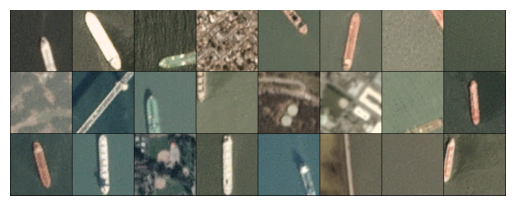

labels: [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0]


In [21]:
# functions to display a grid of images
def imshow(img):
    # convert PyTorch tensor to NumPy array and rearrange dimensions
    # PyTorch: [C, H, W] will be converted to Matplotlib: [H, W, C]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # hide axis ticks
    plt.show()

# get a batch of images and labels from the training set
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# reverse the normalisation so the images look correct
inv_images = inv_normalize(images)

# show a grid of images in the batch
imshow(torchvision.utils.make_grid(inv_images.int()))

# print the labels of the batch
print(f'labels: {labels.numpy()}') # 0 = no-ship, 1 = ship

## 3. Prepare the Use of a Pre-Trained Model

In [24]:
num_classes=2 # binary classification: ship (1) vs no-ship (0)
feature_extract = True # freeze the pretrained layers (only train the final classifier)
use_pretrained = True # load pretrained weights from ImageNet
input_size = 224 # input size expected by VGG11

# freeze all layers except the classifier if feature_extract is True
# it disables gradient computation for all parameters if feature_extracting is True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# load VGG11 with batch normalisation and pretrained weights
# VGG11 is a lightweight convolutional neural network (CNN), faster to train than deeper models like ResNet50
model_ft = models.vgg11_bn(pretrained=use_pretrained)

# freeze all parameters if feature extraction is enabled
set_parameter_requires_grad(model_ft, feature_extract)

# replace the final classifier layer to match our binary output (2 classes)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:29<00:00, 18.2MB/s]


In [25]:
# check if a GPU (CUDA) is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# move the model to the selected device (GPU or CPU)
model_ft = model_ft.to(device)

## 4. Set up Training & Test Loop

Setup the loss function (classification), optimiser and the training and testing loop.

In [26]:
# set up hyper-parameters for loss / optimiser
epochs = 10 # number of training epochs
learning_rate = 0.01 # initial learning rate for the optimiser
criterion = nn.CrossEntropyLoss() # loss function for classification tasks
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9) # stochastic gradient descent optimiser. 'momentum=0.9' helps smooth the updates and can accelerate convergence

In [27]:
# training loop function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # total number of samples in the training set
    num_batches = len(dataloader) # number of batches
    train_loss, train_correct = 0, 0 # accumulators for loss and accuracy

    # loop over all batches in the training DataLoader
    for X, y in dataloader:
        # move data to the same device as the model (GPU or CPU0)
        X = X.to(device)
        y = y.to(device)

        # forward pass: compute predictions and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # back propagation: reset gradients, compute gradients, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate batch loss and correct predictions
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # average loss and accuracy over the entire training set
    train_loss = train_loss/num_batches
    train_correct = train_correct/size

    # print results for this epoch
    print(f"Train_set: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    # track loss and accuracy for plotting or analysis
    train_loss_array.append(train_loss)
    train_correct_array.append(train_correct)

# evaluation loop function
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # total number of samples in the test set
    num_batches = len(dataloader) # number of batches
    test_loss, test_correct = 0, 0 # accumulators for loss and accuracy

    # evaluation mode: no gradient tracking
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # forward pas sonly
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # average loss and accuracy over the test set
    test_loss = test_loss/num_batches
    test_correct = test_correct /size

    # print results for this epoch
    print(f"Test_set: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # track loss and accuracy for later analysis
    test_loss_array.append(test_loss)
    test_correct_array.append(test_correct)

## 5. Fine-Tune with Training Data

In [28]:
# initialise arrays to track training stats
train_loss_array=[] # stores average training loss per epoch
test_loss_array=[] # stores average test loss per epoch
train_correct_array=[] # stores training accuracy per epoch
test_correct_array=[] # stores test accuracy per epoch

# run traiing and evaluation loops
for t in range(epochs): # loop over each epoch
    print(f"Epoch {t+1}\n-------------------------------")

    # run training epoch
    train_loop(train_dataloader, model_ft, criterion, optimizer)

    # evaluate on test data after training epoch
    test_loop(test_dataloader, model_ft, criterion)

# all epochs completed
print("Done!")

# strong initial performance
# - by Epoch 1, the model already achieves:
#     - 87.7% training accuracy
#     - 84.8% test accuracy
# - this indicates that the pretrained VGG11 model is well-suited to the task.
# - likely due to the transfer of useful features from ImageNet to the ship classification task.

# improvement in early epochs
# - from Epoch 1 to Epoch 2:
#     - test accuracy jumps to 90.8%
#     - test loss drops from 0.4158 to 0.2796
# - this suggests early learning leads to optimal generalization.
# - epoch 2 may represent the model’s peak performance on unseen data.

# signs of overfitting in later epochs
# - from Epoch 5 onward:
#     - test loss increases steadily while training accuracy improves.
#     - test accuracy fluctuates and shows signs of decline (e.g., drops to 85.6% in Epoch 6).
#     - training loss continues to fall, but test loss does not → a sign of overfitting.

Epoch 1
-------------------------------
Train_set: 
 Accuracy: 87.7%, Avg loss: 0.296968 

Test_set: 
 Accuracy: 84.8%, Avg loss: 0.415827 

Epoch 2
-------------------------------
Train_set: 
 Accuracy: 89.7%, Avg loss: 0.286770 

Test_set: 
 Accuracy: 90.8%, Avg loss: 0.279602 

Epoch 3
-------------------------------
Train_set: 
 Accuracy: 90.4%, Avg loss: 0.318065 

Test_set: 
 Accuracy: 88.6%, Avg loss: 0.370532 

Epoch 4
-------------------------------
Train_set: 
 Accuracy: 90.6%, Avg loss: 0.295344 

Test_set: 
 Accuracy: 88.8%, Avg loss: 0.335211 

Epoch 5
-------------------------------
Train_set: 
 Accuracy: 89.5%, Avg loss: 0.349463 

Test_set: 
 Accuracy: 88.5%, Avg loss: 0.518136 

Epoch 6
-------------------------------
Train_set: 
 Accuracy: 90.6%, Avg loss: 0.362929 

Test_set: 
 Accuracy: 85.6%, Avg loss: 0.633835 

Epoch 7
-------------------------------
Train_set: 
 Accuracy: 91.3%, Avg loss: 0.296651 

Test_set: 
 Accuracy: 90.2%, Avg loss: 0.336457 

Epoch 8
-----

In [29]:
# save the entire model (architecture + weights)
save_path = "/content/drive/MyDrive/GEOG0125/vgg11_ships_model.pth"
torch.save(model_ft.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/GEOG0125/vgg11_ships_model.pth


In [ ]:
# reload the model later
# model_ft = models.vgg11_bn(pretrained=False)  # pretrained=False since we’ll load weights
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, 2)  # 2 classes: ship, no-ship

# # Load the saved weights
# model_ft.load_state_dict(torch.load("/content/drive/MyDrive/GEOG0125/vgg11_ships_model.pth"))
# model_ft.eval()  # Set model to evaluation mode

In [33]:
# save training stats
import pickle

# save training stats as a dictionary
training_stats = {
    'train_loss': train_loss_array,
    'test_loss': test_loss_array,
    'train_acc': train_correct_array,
    'test_acc': test_correct_array
}

In [32]:
# # load it back later
# with open('/content/drive/MyDrive/GEOG0125/training_stats.pkl', 'wb') as f:
#     pickle.dump(training_stats, f)

## 6. Plot Loss and Accuracy

minimal test loss:0.2796017656869748


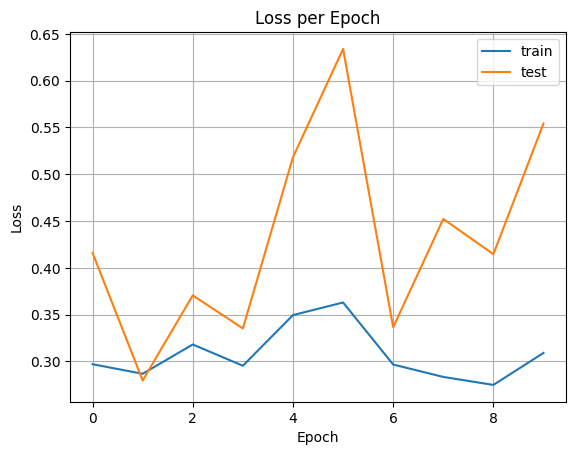

In [30]:
# combine training and test loss into a table
loss_array = zip(train_loss_array, test_loss_array) # pairs (train_loss, test_loss) for each epoch
loss_df = pd.DataFrame(loss_array,columns=['train','test']) # create a DataFrame for plotting

# plot loss over epochs
loss_df.plot()
plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# print the minimum test loss value
print('minimal test loss:' + str(np.min(test_loss_array)))

maximum test accuracy:0.9075


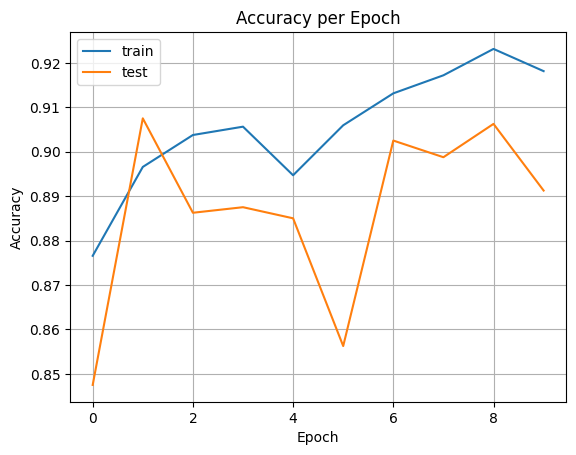

In [31]:
# combine training and test accuracy into a table
acc_array = zip(train_correct_array, test_correct_array) # pairs (train_acc, test_acc) for each epoch
acc_df = pd.DataFrame(acc_array,columns=['train','test']) # create a DataFrame for plotting

# plot accuracy over epoch
acc_df.plot()
plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# print the highest accuracy achieved
print('maximum test accuracy:' + str(np.max(test_correct_array)))

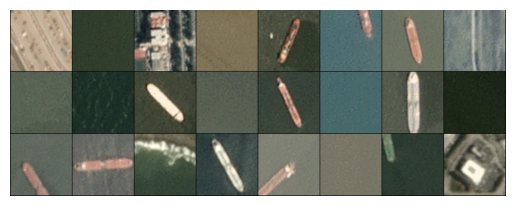

labels: [0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0]
pred: [0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0]
number of correct: 23
number of incorrect: 1


In [35]:
# get a batch of test images and corresponding labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# predict with the model
# move image to GPU if available
pred = model_ft(images.cuda())

# reverse normalisation to view the images
inv_images = inv_normalize(images)

# display image grid
imshow(torchvision.utils.make_grid(inv_images.int()))

# convert predictions and labels to NumPy arrays
y_obs = labels.numpy() # True labels
y_pred = np.argmax(pred.detach().cpu().numpy(),axis=1) # model predictions (class with max score)

# print prediction info
print(f'labels: {y_obs}') # ground truth labels
print(f'pred: {y_pred}') # predicted labels
print(f'number of correct: {np.sum(y_obs == y_pred)}') # correct predictions in this batch
print(f'number of incorrect: {np.sum(y_obs != y_pred)}') # incorrect predictions in this batch

## Visual Explanations

In [47]:
# choose the image index from the current batch to interpret
k=4 # index of the image in the current batch we want to interpret

# get the ground truth label (0 = no-ship, 1 = ship) for the selected image
y_obs[k]

np.int64(1)

In [48]:
# prepare the image for the model:
# - select the k-th image from the batch
# - add a batch dimension using unsqueeze(0)
# - move it to the same device as the model (GPU)
input = images[k].unsqueeze(0).cuda()

# set the target class for attribution
pred_label_idx = torch.tensor([y_obs[k]])

# initialiae Captum's Occlusion explainer with the trained model
occlusion = Occlusion(model_ft)

# compute occlusion attributions:
# - slide a 20x20 mask across the image in strides of 12 pixels
# - occluded regions are set to 0 (black)
# - attribution is calculated for the specified target class
attributions_occ = occlusion.attribute(input,
                                       strides = (3, 12, 12), # how far the occlusion window moves (channels, height, width)
                                       target=pred_label_idx, # class to explain
                                       sliding_window_shapes=(3,20, 20), # size of the window to occlude at each step
                                       baselines=0) # replace occluded regions with zeros

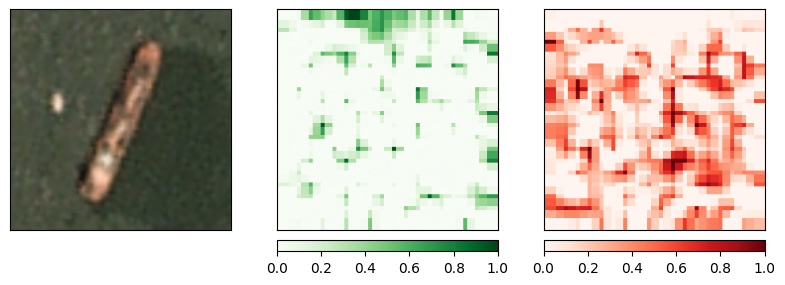

In [49]:
# visualise the results:
# - show the original image, total attribution heatmap, positive and negative contributions
# - convert tensors to NumPy arrays and reverse the normalisation
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)), # attribution map in [H, W, C]
                                      np.transpose(inv_normalize(images[k]).squeeze().cpu().detach().numpy(), (1,2,0)).astype(np.uint8), # original image
                                      ["original_image", "heat_map", "heat_map"], # display: original + 2 heatmaps
                                      ["all", "positive","negative"], # attribution types to show
                                      show_colorbar=True, # show colour scale
                                      outlier_perc=2) # clip outlier attribution values for better visualisation